### Import Libraries

In [63]:
import re, os
from pathlib import Path
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx

### Data Preparation for Apriori Algorithm

In [2]:
df = pl.read_csv('data/dataset.csv')

In [ ]:
# Identify columns
disease_col = 'Disease'
symptom_cols = [c for c in df.columns if c.startswith("Symptom")]

In [22]:
# Lowercase and remove spacing in symptom columns
df = df.with_columns([
    pl.col(c).str.to_lowercase().str.replace_all(' ', '').alias(c) for c in symptom_cols
]).with_columns(
    pl.col('Disease').str.strip_chars_end().alias('Disease')
)

Looking through all symptoms to identify similar / duplicate.

In [23]:
# Getting all symptoms in dataset
unique_symptoms = (
    df.select(symptom_cols)
      .unpivot()                        # stacks all columns into 2 columns: variable, value
      .select('value')
      .drop_nulls()
      .unique()
      .to_series()
      .sort()
      .to_list()
)

unique_symptoms

['abdominal_pain',
 'abnormal_menstruation',
 'acidity',
 'acute_liver_failure',
 'altered_sensorium',
 'anxiety',
 'back_pain',
 'belly_pain',
 'blackheads',
 'bladder_discomfort',
 'blister',
 'blood_in_sputum',
 'bloody_stool',
 'blurred_and_distorted_vision',
 'breathlessness',
 'brittle_nails',
 'bruising',
 'burning_micturition',
 'chest_pain',
 'chills',
 'cold_hands_and_feets',
 'coma',
 'congestion',
 'constipation',
 'continuous_feel_of_urine',
 'continuous_sneezing',
 'cough',
 'cramps',
 'dark_urine',
 'dehydration',
 'depression',
 'diarrhoea',
 'dischromic_patches',
 'distention_of_abdomen',
 'dizziness',
 'drying_and_tingling_lips',
 'enlarged_thyroid',
 'excessive_hunger',
 'extra_marital_contacts',
 'family_history',
 'fast_heart_rate',
 'fatigue',
 'fluid_overload',
 'foul_smell_ofurine',
 'headache',
 'high_fever',
 'hip_joint_pain',
 'history_of_alcohol_consumption',
 'increased_appetite',
 'indigestion',
 'inflammatory_nails',
 'internal_itching',
 'irregular_sugar

| abdominal_pain | abnormal_menstruation | acidity | acute_liver_failure | altered_sensorium | anxiety |
| --- | --- | --- | --- | --- | --- |
| back_pain | belly_pain | blackheads | bladder_discomfort | blister | blood_in_sputum |
| bloody_stool | blurred_and_distorted_vision | breathlessness | brittle_nails | bruising | burning_micturition |
| chest_pain | chills | cold_hands_and_feets | coma | congestion | constipation |
| continuous_feel_of_urine | continuous_sneezing | cough | cramps | dark_urine | dehydration |
| depression | diarrhoea | dischromic_patches | distention_of_abdomen | dizziness | drying_and_tingling_lips |
| enlarged_thyroid | excessive_hunger | extra_marital_contacts | family_history | fast_heart_rate | fatigue |
| fluid_overload | foul_smell_ofurine | headache | high_fever | hip_joint_pain | history_of_alcohol_consumption |
| increased_appetite | indigestion | inflammatory_nails | internal_itching | irregular_sugar_level | irritability |
| irritation_in_anus | itching | joint_pain | knee_pain | lack_of_concentration | lethargy |
| loss_of_appetite | loss_of_balance | loss_of_smell | malaise | mild_fever | mood_swings |
| movement_stiffness | mucoid_sputum | muscle_pain | muscle_wasting | muscle_weakness | nausea |
| neck_pain | nodal_skin_eruptions | obesity | pain_behind_the_eyes | pain_during_bowel_movements | pain_in_anal_region |
| painful_walking | palpitations | passage_of_gases | patches_in_throat | phlegm | polyuria |
| prominent_veins_on_calf | puffy_face_and_eyes | pus_filled_pimples | receiving_blood_transfusion | receiving_unsterile_injections | red_sore_around_nose |
| red_spots_over_body | redness_of_eyes | restlessness | runny_nose | rusty_sputum | scurring |
| shivering | silver_like_dusting | sinus_pressure | skin_peeling | skin_rash | slurred_speech |
| small_dents_in_nails | spinning_movements | spotting_urination | stiff_neck | stomach_bleeding | stomach_pain |
| sunken_eyes | sweating | swelled_lymph_nodes | swelling_joints | swelling_of_stomach | swollen_blood_vessels |
| swollen_extremeties | swollen_legs | throat_irritation | toxic_look_(typhos) | ulcers_on_tongue | unsteadiness |
| visual_disturbances | vomiting | watering_from_eyes | weakness_in_limbs | weakness_of_one_body_side | weight_gain |
| weight_loss | yellow_crust_ooze | yellow_urine | yellowing_of_eyes | yellowish_skin |  |

#### Mapped Symptom Explanations

Digestive / Abdominal
- `belly_pain`, `stomach_pain` → **abdominal_pain** — same symptom phrasing.
- `acidity` → **indigestion** — acidity is a subset of indigestion.
- `distention_of_abdomen`, `passage_of_gases` → **bloating** — gas buildup / distention.
- `pain_during_bowel_movements`, `pain_in_anal_region` → **anal_pain** — same site of pain.
- `bloody_stool` → **stomach_bleeding** — related GI bleeding |ndicator.

Urinary
- `burning_micturition`, `foul_smell_ofurine`, `continuous_feel_of_urine`, `spotting_urination` → **urinary_discomfort** — grouped UTI symptoms.
- `polyuria` → **urinary_frequency** — frequent urination variant.
- `dark_urine`, `yellow_urine` → **jaundice** — bilirubin buildup sign.

Liver / Jaundice
- `yellowing_of_eyes`, `yellowish_skin` → **jaundice** — hepatic manifestation.

Cardiovascular
- `fast_heart_rate` → **palpitations** — overlapping cardiac sensation.
- `puffy_face_and_eyes`, `fluid_overload`, `swollen_extremeties`, `swollen_legs` → **edema** — fluid retention.
- `prominent_veins_on_calf`, `swollen_blood_vessels` → **varicose_veins** — same venous dilation.

Musculoskeletal
- `hip_joint_pain`, `knee_pain`, `painful_walking` → **joint_pain** — identical anatomical complaint.
- `movement_stiffness`, `stiff_neck` → **stiffness** — same concept.
- `weakness_in_limbs` → **muscle_weakness** — generalized under same label.

Fever / Infection
- `high_fever`, `mild_fever`, `toxic_look_(typhos)` → **fever** — intensity differences merged.
- `shivering` → **chills** — same phenomenon.

Eye / Vision
- `blurred_and_distorted_vision` → **visual_disturbances** — same condition.
- `redness_of_eyes`, `watering_from_eyes` → **eye_irritation** — conjunctival symptom cluster.

Respiratory / ENT
- `congestion`, `sinus_pressure` → **nasal_congestion** — upper-airway overlap.
- `mucoid_sputum`, `rusty_sputum` → **phlegm** — sputum variations.
- `patches_in_throat` → **throat_irritation** — same sore-throat complaint.

Skin / Nails
- `blackheads`, `pus_filled_pimples`, `red_sore_around_nose` → **acne** — acneiform lesions.
- `blister`, `red_spots_over_body` → **skin_rash** — skin eruption type.
- `scurring`, `silver_like_dusting` → **skin_peeling** — exfoliative lesions.
- `brittle_nails`, `inflammatory_nails`, `small_dents_in_nails` → **nail_abnormalities** — grouped nail conditions.

Neurological / Balance
- `loss_of_balance`, `spinning_movements`, `unsteadiness` → **vertigo** — balance disorder.

Energy / Fatigue
- `lethargy`, `malaise` → **fatigue** — same low-energy symptom.

Metabolic / Systemic
- `increased_appetite` → **excessive_hunger** — same metabolic symptom.
- `sunken_eyes` → **dehydration** — dehydration marker.


In [24]:
symptom_synonyms = {
    "abdominal_pain": "abdominal_pain",
    "abnormal_menstruation": "abnormal_menstruation",
    "acidity": "indigestion",
    "acute_liver_failure": "acute_liver_failure",
    "altered_sensorium": "altered_sensorium",
    "anxiety": "anxiety",
    "back_pain": "back_pain",
    "belly_pain": "abdominal_pain",
    "blackheads": "acne",
    "bladder_discomfort": "bladder_discomfort",
    "blister": "skin_rash",
    "blood_in_sputum": "rusty_sputum",
    "bloody_stool": "stomach_bleeding",
    "blurred_and_distorted_vision": "visual_disturbances",
    "breathlessness": "breathlessness",
    "brittle_nails": "nail_abnormalities",
    "bruising": "bruising",
    "burning_micturition": "urinary_discomfort",
    "chest_pain": "chest_pain",
    "chills": "chills",
    "cold_hands_and_feets": "cold_extremities",
    "coma": "coma",
    "congestion": "nasal_congestion",
    "constipation": "constipation",
    "continuous_feel_of_urine": "urinary_discomfort",
    "continuous_sneezing": "sneezing",
    "cough": "cough",
    "cramps": "cramps",
    "dark_urine": "jaundice",
    "dehydration": "dehydration",
    "depression": "depression",
    "diarrhoea": "diarrhoea",
    "dischromic_patches": "dischromic_patches",
    "distention_of_abdomen": "bloating",
    "dizziness": "dizziness",
    "drying_and_tingling_lips": "dry_lips",
    "enlarged_thyroid": "enlarged_thyroid",
    "excessive_hunger": "excessive_hunger",
    "extra_marital_contacts": "extra_marital_contacts",
    "family_history": "family_history",
    "fast_heart_rate": "palpitations",
    "fatigue": "fatigue",
    "fluid_overload": "edema",
    "foul_smell_ofurine": "urinary_discomfort",
    "headache": "headache",
    "high_fever": "fever",
    "hip_joint_pain": "joint_pain",
    "history_of_alcohol_consumption": "history_of_alcohol_consumption",
    "increased_appetite": "excessive_hunger",
    "indigestion": "indigestion",
    "inflammatory_nails": "nail_abnormalities",
    "internal_itching": "itching",
    "irregular_sugar_level": "irregular_sugar_level",
    "irritability": "irritability",
    "irritation_in_anus": "irritation_in_anus",
    "itching": "itching",
    "joint_pain": "joint_pain",
    "knee_pain": "joint_pain",
    "lack_of_concentration": "lack_of_concentration",
    "lethargy": "fatigue",
    "loss_of_appetite": "loss_of_appetite",
    "loss_of_balance": "vertigo",
    "loss_of_smell": "loss_of_smell",
    "malaise": "fatigue",
    "mild_fever": "fever",
    "mood_swings": "mood_swings",
    "movement_stiffness": "stiffness",
    "mucoid_sputum": "phlegm",
    "muscle_pain": "muscle_pain",
    "muscle_wasting": "muscle_wasting",
    "muscle_weakness": "muscle_weakness",
    "nausea": "nausea",
    "neck_pain": "neck_pain",
    "nodal_skin_eruptions": "nodal_skin_eruptions",
    "obesity": "obesity",
    "pain_behind_the_eyes": "pain_behind_the_eyes",
    "pain_during_bowel_movements": "anal_pain",
    "pain_in_anal_region": "anal_pain",
    "painful_walking": "joint_pain",
    "palpitations": "palpitations",
    "passage_of_gases": "bloating",
    "patches_in_throat": "throat_irritation",
    "phlegm": "phlegm",
    "polyuria": "urinary_frequency",
    "prominent_veins_on_calf": "varicose_veins",
    "puffy_face_and_eyes": "edema",
    "pus_filled_pimples": "acne",
    "receiving_blood_transfusion": "receiving_blood_transfusion",
    "receiving_unsterile_injections": "receiving_unsterile_injections",
    "red_sore_around_nose": "acne",
    "red_spots_over_body": "skin_rash",
    "redness_of_eyes": "eye_irritation",
    "restlessness": "restlessness",
    "runny_nose": "runny_nose",
    "rusty_sputum": "phlegm",
    "scurring": "skin_peeling",
    "shivering": "chills",
    "silver_like_dusting": "skin_peeling",
    "sinus_pressure": "nasal_congestion",
    "skin_peeling": "skin_peeling",
    "skin_rash": "skin_rash",
    "slurred_speech": "slurred_speech",
    "small_dents_in_nails": "nail_abnormalities",
    "spinning_movements": "vertigo",
    "spotting_urination": "urinary_discomfort",
    "stiff_neck": "stiffness",
    "stomach_bleeding": "stomach_bleeding",
    "stomach_pain": "abdominal_pain",
    "sunken_eyes": "dehydration",
    "sweating": "sweating",
    "swelled_lymph_nodes": "swollen_lymph_nodes",
    "swelling_joints": "swelling_joints",
    "swelling_of_stomach": "abdominal_swelling",
    "swollen_blood_vessels": "varicose_veins",
    "swollen_extremeties": "edema",
    "swollen_legs": "edema",
    "throat_irritation": "throat_irritation",
    "toxic_look_(typhos)": "fever",
    "ulcers_on_tongue": "mouth_ulcers",
    "unsteadiness": "vertigo",
    "visual_disturbances": "visual_disturbances",
    "vomiting": "vomiting",
    "watering_from_eyes": "eye_irritation",
    "weakness_in_limbs": "muscle_weakness",
    "weakness_of_one_body_side": "weakness_of_one_body_side",
    "weight_gain": "weight_gain",
    "weight_loss": "weight_loss",
    "yellow_crust_ooze": "yellow_crust_ooze",
    "yellow_urine": "jaundice",
    "yellowing_of_eyes": "jaundice",
    "yellowish_skin": "jaundice"
}

In [25]:
df_mapped = df.with_columns([
    pl.col(c)
    .map_elements(lambda x: symptom_synonyms.get(x, x), return_dtype=pl.String)
    .alias(c)
    for c in symptom_cols
])

df_mapped.write_csv('data/mapped_dataset.csv')

In [26]:
# Getting all symptoms in dataset
unique_symptoms2 = (
    df_mapped.select(symptom_cols)
      .unpivot()                        # stacks all columns into 2 columns: variable, value
      .select('value')
      .drop_nulls()
      .unique()
      .to_series()
      .sort()
      .to_list()
)

len(unique_symptoms2)

85

Reduced from 131 symptoms to 85 symptoms

### Applying Apriori Algorithm to find Frequent Itemset

In [4]:
df_mapped = pl.read_csv('data/mapped_dataset.csv')
disease_list = df_mapped.get_column('Disease').unique().sort().to_list()

disease_col = 'Disease'
symptom_cols = [c for c in df_mapped.columns if c.startswith("Symptom")]

transactions = {}
for disease in disease_list:
    transactions[disease] = []
    disease_df = df_mapped.filter(
        pl.col(disease_col).eq(disease)
    )

    for row in disease_df.iter_rows(named=True):
        items = set()
        for c in symptom_cols:
            val = row[c]
            if val and isinstance(val, str) and val != "":
                parts = [p.strip() for p in re.split(r"[;,/|]", val) if p.strip()]
                items.update(parts)
        if items:
            transactions[disease].append(frozenset(items))

In [30]:
output_dir = 'output'
os.makedirs(output_dir, exist_ok = True)

te = TransactionEncoder()
min_support = 0.05

test = {}

for disease, txn_list in transactions.items():
    disease_dir = f'{output_dir}/{disease}'
    os.makedirs(disease_dir, exist_ok = True)

    te_ary = te.fit(txn_list).transform(txn_list)
    df_enc = pd.DataFrame(te_ary, columns=te.columns_)

    # Apriori Algorithm
    frequent_itemsets = apriori(df_enc, min_support=min_support, use_colnames=True)
    frequent_itemsets["length"] = frequent_itemsets["itemsets"].apply(lambda x: len(x))
    frequent_itemsets = frequent_itemsets.sort_values(["length", "support"], ascending=[True, False])

    ## Keep only length <= 5 combinations.
    frequent_itemsets = frequent_itemsets[frequent_itemsets["length"] <= 5]

    # Save Results
    frequent_itemsets.to_pickle(f"{disease_dir}/frequent_itemsets_{disease}.pkl")

    test[disease] = len(frequent_itemsets)

### Finding Association Rules

In [32]:
output_dir = Path('output')

for folder in output_dir.iterdir():
    if folder.is_dir():
        disease = folder.name
        disease_dir = f'{output_dir}/{disease}'
        print(disease)

        for file in folder.iterdir():
            if file.is_file() and file.suffix == '.pkl':

                frequent_itemsets = pd.read_pickle(file)
                rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
                rules = rules.sort_values(["lift", "confidence", "support"], ascending=False)
                rules.to_csv(f"{disease_dir}/association_rules_{disease}.csv", index=False)

(vertigo) Paroymsal  Positional Vertigo
Acne
AIDS
Alcoholic hepatitis
Allergy
Arthritis
Bronchial Asthma
Cervical spondylosis
Chicken pox


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:

Chronic cholestasis
Common Cold


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Dengue


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Diabetes
Dimorphic hemmorhoids(piles)
Drug Reaction


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Fungal infection
Gastroenteritis
GERD
Heart attack
hepatitis A
Hepatitis B
Hepatitis C
Hepatitis D


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Hepatitis E


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Hypertension
Hyperthyroidism


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Hypoglycemia


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Hypothyroidism


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Impetigo
Jaundice
Malaria
Migraine
Osteoarthristis
Paralysis (brain hemorrhage)
Peptic ulcer diseae
Pneumonia


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:

Psoriasis
Tuberculosis


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Typhoid
Urinary tract infection
Varicose veins


d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\Github\SC4020\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


### Most frequent itemsets per disease

In [39]:
def top_itemsets_plot(df, size=2, topn=20, save_path=None):
    sub = df[df["length"] == size].nlargest(topn, "support")
    if sub.empty:
        return

    plt.figure(figsize=(10, 6))
    bars = plt.barh(sub["itemsets"].astype(str), sub["support"])
    plt.xlabel("Support")
    plt.title(f"Top {size}-itemsets by Support")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # ✅ Add support value on bars
    for bar, value in zip(bars, sub["support"]):
        plt.text(
            bar.get_width(),           # x position → end of the bar
            bar.get_y() + bar.get_height() / 2,  # y position → middle of bar
            f"{value:.3f}",            # format to 3 decimals
            va="center",
            ha="left",
            fontsize=8
        )

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()  # ✅ avoid memory leak
    else:
        plt.show()

In [40]:
output_dir = Path('output')

for folder in output_dir.iterdir():
    if folder.is_dir():
        disease = folder.name
        disease_dir = f'{output_dir}/{disease}'
        print(disease)

        for file in folder.iterdir():
            if file.is_file() and file.suffix == '.pkl':

                frequent_itemsets = pd.read_pickle(file)
                for size in [1, 2, 3, 4, 5]:
                    save_path = folder / f"top_{size}_itemsets.png"
                    top_itemsets_plot(
                        frequent_itemsets,
                        size=size,
                        save_path=save_path
                    )

(vertigo) Paroymsal  Positional Vertigo
Acne
AIDS
Alcoholic hepatitis
Allergy
Arthritis
Bronchial Asthma
Cervical spondylosis
Chicken pox
Chronic cholestasis
Common Cold
Dengue
Diabetes
Dimorphic hemmorhoids(piles)
Drug Reaction
Fungal infection
Gastroenteritis
GERD
Heart attack
hepatitis A
Hepatitis B
Hepatitis C
Hepatitis D
Hepatitis E
Hypertension
Hyperthyroidism
Hypoglycemia
Hypothyroidism
Impetigo
Jaundice
Malaria
Migraine
Osteoarthristis
Paralysis (brain hemorrhage)
Peptic ulcer diseae
Pneumonia
Psoriasis
Tuberculosis
Typhoid
Urinary tract infection
Varicose veins


### Top Rules per diseases

In [ ]:
def show_top_rules_by_disease(output_dir="output", topn=10):
    output_dir = Path(output_dir)

    for folder in output_dir.iterdir():
        if not folder.is_dir():
            continue

        disease = folder.name
        rules_file = folder / f"association_rules_{disease}.csv"

        if not rules_file.exists():
            continue

        rules = pd.read_csv(rules_file)

        # Make readable
        rules["antecedents"] = rules["antecedents"].apply(eval)
        rules["consequents"] = rules["consequents"].apply(eval)

        print(f"\n===== {disease} =====")
        top_rules = rules.nlargest(topn, "lift")[["antecedents", "consequents", "confidence", "lift", "support"]]
        print(top_rules.to_string(index=False))


In [60]:
show_top_rules_by_disease(topn=5)


===== (vertigo) Paroymsal  Positional Vertigo =====
         antecedents consequents  confidence  lift  support
          (headache)   (vertigo)         1.0   1.0     0.95
            (nausea)   (vertigo)         1.0   1.0     0.95
          (vomiting)   (vertigo)         1.0   1.0     0.95
  (nausea, headache)   (vertigo)         1.0   1.0     0.90
(headache, vomiting)   (vertigo)         1.0   1.0     0.90

===== Acne =====
              antecedents    consequents  confidence  lift  support
              (skin_rash)         (acne)        1.00   1.0     0.95
           (skin_peeling)         (acne)        1.00   1.0     0.90
(skin_peeling, skin_rash)         (acne)        1.00   1.0     0.85
                   (acne)    (skin_rash)        0.95   1.0     0.95
                   (acne) (skin_peeling)        0.90   1.0     0.90

===== AIDS =====
             antecedents              consequents  confidence     lift  support
(extra_marital_contacts)                  (fever)    0.944444 0

### Rules Summary

In [46]:
def create_rules_summary(output_dir="output"):
    rows = []
    output_dir = Path(output_dir)

    for folder in output_dir.iterdir():
        if not folder.is_dir():
            continue

        disease = folder.name
        rules_file = folder / f"association_rules_{disease}.csv"
        if not rules_file.exists():
            continue

        rules = pd.read_csv(rules_file)
        if rules.empty:
            continue

        rows.append({
            "disease": disease,
            "num_rules": len(rules),
            "avg_support": rules["support"].mean(),
            "avg_confidence": rules["confidence"].mean(),
            "avg_lift": rules["lift"].mean(),
            "max_lift": rules["lift"].max(),
        })

    summary_df = pd.DataFrame(rows)
    print("\n===== SUMMARY ACROSS DISEASES =====")
    print(summary_df.sort_values("avg_lift", ascending=False).to_string(index=False))
    return summary_df


In [47]:
summary_df = create_rules_summary()



===== SUMMARY ACROSS DISEASES =====
                                disease  num_rules  avg_support  avg_confidence  avg_lift  max_lift
                Urinary tract infection          2     0.950000        0.975000  1.000000  1.000000
                              Psoriasis         50     0.924000        0.961053  0.999003  1.000000
                        Osteoarthristis         12     0.916667        0.957018  0.998615  1.000000
                         Hypothyroidism      19580     0.915526        0.956393  0.998533  1.000000
                            Hepatitis B       1372     0.909038        0.952990  0.998369  1.000000
                            Common Cold     112140     0.904494        0.950352  0.997956  1.000000
                                 Dengue      32142     0.902293        0.949200  0.997903  1.000000
                           Tuberculosis      76440     0.898163        0.946909  0.997652  1.000000
                                   Acne         12     0.875000

### Rules Metrics Heatmap

In [61]:
def plot_rules_heatmap(rules_file):
    rules = pd.read_csv(rules_file)
    if rules.empty:
        print("⚠️ No rules to plot")
        return

    plt.figure(figsize=(8, 6))
    sns.heatmap(rules[["support", "confidence", "lift"]].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap of Rule Metrics")
    plt.show()


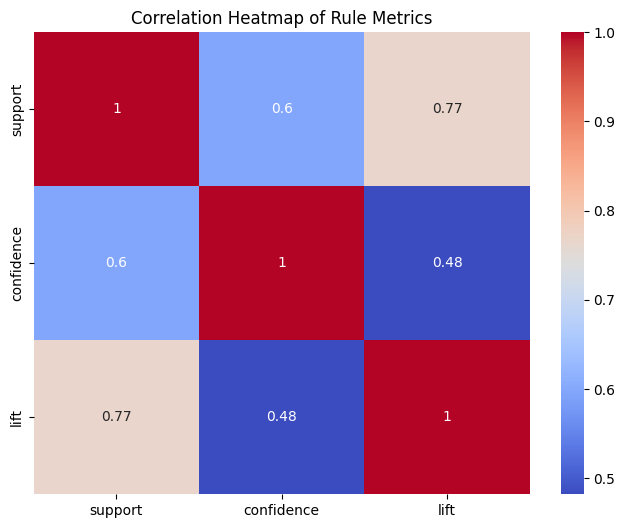

In [50]:
plot_rules_heatmap("output/Dengue/association_rules_Dengue.csv")


### Rules Network

In [64]:
def plot_rules_network(rules_file, topn=15, save_path=None):
    rules = pd.read_csv(rules_file)
    if rules.empty:
        print(f"⚠️ No rules in {rules_file}")
        return

    # Convert the string representation of sets into python sets
    rules["antecedents"] = rules["antecedents"].apply(eval)
    rules["consequents"] = rules["consequents"].apply(eval)

    # Select top N rules based on lift
    rules = rules.nlargest(topn, "lift")

    G = nx.DiGraph()

    for _, r in rules.iterrows():
        for a in r["antecedents"]:
            for c in r["consequents"]:
                G.add_edge(a, c, weight=r["lift"])

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000, font_size=8, font_weight="bold")
    plt.title("Association Rule Network Graph")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Saved: {save_path}")
    else:
        plt.show()

In [65]:
output_dir = Path("output")

for folder in output_dir.iterdir():
    if not folder.is_dir():
        continue

    disease = folder.name
    rules_file = folder / f"association_rules_{disease}.csv"

    if rules_file.exists():
        save_path = folder / f"network_graph_{disease}.png"
        plot_rules_network(rules_file, topn=15, save_path=save_path)
    else:
        print(f"⚠️ No rules CSV found for: {disease}")


✅ Saved: output\(vertigo) Paroymsal  Positional Vertigo\network_graph_(vertigo) Paroymsal  Positional Vertigo.png
✅ Saved: output\Acne\network_graph_Acne.png
✅ Saved: output\AIDS\network_graph_AIDS.png
✅ Saved: output\Alcoholic hepatitis\network_graph_Alcoholic hepatitis.png
✅ Saved: output\Allergy\network_graph_Allergy.png
✅ Saved: output\Arthritis\network_graph_Arthritis.png
✅ Saved: output\Bronchial Asthma\network_graph_Bronchial Asthma.png
✅ Saved: output\Cervical spondylosis\network_graph_Cervical spondylosis.png
✅ Saved: output\Chicken pox\network_graph_Chicken pox.png
✅ Saved: output\Chronic cholestasis\network_graph_Chronic cholestasis.png
✅ Saved: output\Common Cold\network_graph_Common Cold.png
✅ Saved: output\Dengue\network_graph_Dengue.png
✅ Saved: output\Diabetes\network_graph_Diabetes.png
✅ Saved: output\Dimorphic hemmorhoids(piles)\network_graph_Dimorphic hemmorhoids(piles).png
✅ Saved: output\Drug Reaction\network_graph_Drug Reaction.png
✅ Saved: output\Fungal infection